In [1]:
import keras 
import tensorflow as tf
import functools

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from matplotlib import image
from matplotlib import pyplot as plt
import cv2 

import pandas as pd
import numpy as np
from numpy import asarray
import random
plt.style.use('default')



In [2]:
# upload data from gdrive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
def Squre_Crop(filename, size =256):
    ''' 
    Image is cropped, a sqare region with random location across original image
    '''
    
    image = Image.open(filename)
    #print('Image size:',image.size)
    
    width, height = image.size
    
    # if both image size >= size(256), crop size x size(256 x 256)
    if (width >= size) & (height >= size):
        left = random.randint(0, width-size)
        upper = random.randint(0, height-size)
        
        box = (left, upper, left+size, upper+size)  # (left, upper, right, lower)
        cropped_image = image.crop(box)
    #cropped_image.save('cropped_image.jpg')
    
    # if one size is smaller than 256, crop the min_size x min_size, 
    # then resize to 256x256
    
    else:
        crop_size = min(width, height)
        left = random.randint(0, width-crop_size)
        upper = random.randint(0, height-crop_size)
        
        box = (left, upper, left+crop_size, upper+crop_size)  # (left, upper, right, lower)
        
        small_cropped_image = image.crop(box)
        cropped_image = small_cropped_image.resize((size, size))  # resize to size x size
        
    #print('Copped image size',cropped_image.size) # Print size of cropped image
    
    return cropped_image


def JPGtoArrary(image):
    '''
    convert jpg file image to numpy array. if there is only one channel, set all the 3 channels to be idential
    '''

    data = asarray(image)
    #print('Data type:',type(data))
    # summarize shape
    #print('Data shape:',data.shape)
    
    if len(data.shape) == 3:  #  3 channels
        return data
    
    elif len(data.shape) == 2:  # black & white one channel
        stacked_data = np.stack((data,)*3, axis=-1)
        print('Data is expaned, current shape:', stacked_data.shape)  # Notice when processing black white image
        return stacked_data 
    
    else:
        print('Wrong Image Format!')
        

def Squre_Reshape(filename, size =256):
    ''' 
    Image is reshaped, all the images are reshaped to 256 * 256
    '''
    
    image = Image.open(filename)
    #print('Image size:',image.size)

    new_image = image.resize((size, size))
    #new_image.save('test_image.jpg')
    
    return new_image
        
        

In [4]:
def model_demo(image_path, model_path, art_dict, sample_size, output_num, reshape = False):


    top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
    top5_acc.__name__ = 'top5_acc'
    model = keras.models.load_model(model_path, custom_objects={"top5_acc": top5_acc})  # load model with custom item 
    
    if reshape == True:
      image_array = JPGtoArrary(Squre_Reshape(image_path, sample_size))
      
    else:
      image_array = JPGtoArrary(Squre_Crop(image_path, sample_size))

    input_data = np.reshape(image_array, (1, sample_size, sample_size, 3))/255
    #print(input_data)
    
    y = model.predict(input_data)
    index = np.argsort(-y)


    #for i in index[0,:output_num]:
       # name_list += art_dict['name'][i]

    keys = list(index[0,:output_num])
    names = list( map(art_dict['name'].get, keys) )
    name_str = '\n'.join(names)

    img_data = cv2.imread(image_path)
    whole_image = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)

    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (50, 50) # org
    fontScale = 1  # fontScale
    color = (0, 255, 0)
    thickness = 2   # Line thickness of 2 px

   
    # Using cv2.putText() method
    image_text = cv2.putText(whole_image, name_str, org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)  
 

    plt.imshow(image_text)
    plt.axis('off')


In [6]:
def model_demo(image_path, model_path, art_dict, sample_size, output_num, reshape = False):


    top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
    top5_acc.__name__ = 'top5_acc'
    model = keras.models.load_model(model_path, custom_objects={"top5_acc": top5_acc})  # load model with custom item 
    
    if reshape == True:
      image_array = JPGtoArrary(Squre_Reshape(image_path, sample_size))
      
    else:
      image_array = JPGtoArrary(Squre_Crop(image_path, sample_size))

    input_data = np.reshape(image_array, (1, sample_size, sample_size, 3))/255
    #print(input_data)
    
    y = model.predict(input_data)
    index = np.argsort(-y)


    #for i in index[0,:output_num]:
       # name_list += art_dict['name'][i]

    keys = list(index[0,:output_num])
    names = list( map(art_dict['name'].get, keys) )

    img_data = cv2.imread(image_path)
    whole_image = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)

    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (50, 50) # org
    fontScale = 1.5  # fontScale
    color = (0, 255, 0)
    thickness = 3   # Line thickness of 2 px

    i = 0
    for line in names:
        textsize = cv2.getTextSize(line, font, fontScale, thickness)[0]

        gap = textsize[1] + 5

        y = int((whole_image.shape[0] + textsize[1]) / 4) + i * gap
        x = 10#for center alignment => int((img.shape[1] - textsize[0]) / 2)

        cv2.putText(whole_image, line, (x, y), font, fontScale, (255,255,255), thickness, lineType = cv2.LINE_AA)
        i +=1

   
    plt.imshow(whole_image)
    plt.axis('off')


In [7]:
path = 'gdrive/MyDrive/w251/w251_final_project_data/'
df = pd.read_csv(path+'artists.csv')
art_data = df[['id', 'name']]
art_data.set_index('id',inplace = True)
art_dict =  art_data.T.to_dict('index') # artist name dictionary 
print(art_dict)

{'name': {0: 'Amedeo Modigliani', 1: 'Vasiliy Kandinskiy', 2: 'Diego Rivera', 3: 'Claude Monet', 4: 'Rene Magritte', 5: 'Salvador Dali', 6: 'Edouard Manet', 7: 'Andrei Rublev', 8: 'Vincent van Gogh', 9: 'Gustav Klimt', 10: 'Hieronymus Bosch', 11: 'Kazimir Malevich', 12: 'Mikhail Vrubel', 13: 'Pablo Picasso', 14: 'Peter Paul Rubens', 15: 'Pierre-Auguste Renoir', 16: 'Francisco Goya', 17: 'Frida Kahlo', 18: 'El Greco', 19: 'Albrecht Dürer', 20: 'Alfred Sisley', 21: 'Pieter Bruegel', 22: 'Marc Chagall', 23: 'Giotto di Bondone', 24: 'Sandro Botticelli', 25: 'Caravaggio', 26: 'Leonardo da Vinci', 27: 'Diego Velazquez', 28: 'Henri Matisse', 29: 'Jan van Eyck', 30: 'Edgar Degas', 31: 'Rembrandt', 32: 'Titian', 33: 'Henri de Toulouse-Lautrec', 34: 'Gustave Courbet', 35: 'Camille Pissarro', 36: 'William Turner', 37: 'Edvard Munch', 38: 'Paul Cezanne', 39: 'Eugene Delacroix', 40: 'Henri Rousseau', 41: 'Georges Seurat', 42: 'Paul Klee', 43: 'Piet Mondrian', 44: 'Joan Miro', 45: 'Andy Warhol', 46:

In [ ]:
#direct = '/Users/haoyuzhang/Downloads/archive/images/images/'
#artist = 'Vincent_van_Gogh'
filename = 'Vincent_van_Gogh_1.jpg'
size = 64
#model_path = 'models/model4b'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/model4b'

#image_array = JPGtoArrary(Squre_Crop(direct + artist + '/' + filename, size))


image_array = JPGtoArrary(Squre_Crop(path+'Vincent_van_Gogh_1.jpg', size))

input_data = np.reshape(image_array, (1, size, size, 3))/255



top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'

      
model = keras.models.load_model(model_path, custom_objects={"top5_acc": top5_acc})  # load model with custom item
y = model.predict(input_data)


print(y)



[[1.6508639e-05 1.9825211e-06 1.2525080e-09 6.7850408e-05 5.6607561e-05
  5.1164011e-06 8.1649171e-07 1.2295169e-04 6.5897098e-03 2.6683068e-05
  3.6553135e-06 3.6821211e-06 8.5482001e-04 1.4461577e-04 1.3805084e-06
  1.0853130e-04 7.3449156e-04 2.0083317e-09 1.9045936e-09 1.0738709e-05
  2.0002876e-04 3.5939788e-06 1.1529955e-05 7.5209704e-05 3.5114026e-05
  1.8114652e-07 3.1616189e-06 5.0640489e-07 8.9567366e-06 7.2451352e-05
  1.0559576e-01 7.8867515e-07 9.0847361e-06 3.1061012e-05 8.2202369e-08
  9.2531933e-05 3.7451118e-05 1.1032156e-07 3.7324648e-07 2.0039008e-09
  2.1455348e-06 9.1721915e-08 2.0570858e-05 1.6482201e-06 1.6184284e-05
  4.4919875e-07 8.8502318e-01 7.4976206e-06 7.5570803e-08 5.6320456e-12]]


In [ ]:
print(art_dict['name'][np.argmax(y)])
print()

index = np.argsort(-y)
for i in index[0,:5]:
  print(art_dict['name'][i])

keys = list(index[0,:5])

values = list( map(art_dict['name'].get, keys) )

print(values)

print('\n'.join(values))


Paul Gauguin

Paul Gauguin
Edgar Degas
Vincent van Gogh
Mikhail Vrubel
Francisco Goya
['Paul Gauguin', 'Edgar Degas', 'Vincent van Gogh', 'Mikhail Vrubel', 'Francisco Goya']
Paul Gauguin
Edgar Degas
Vincent van Gogh
Mikhail Vrubel
Francisco Goya


## Model 2c Reshape(256x256)

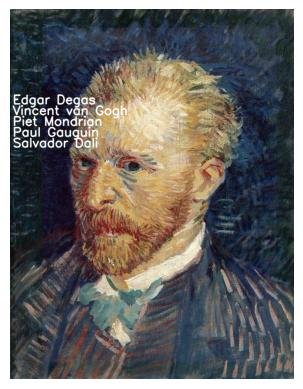

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/Vincent_van_Gogh_1.jpg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/model_2c'
sample_size = 256
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

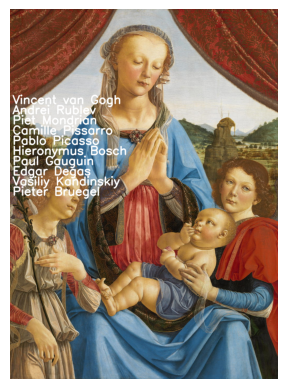

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/Leonardo_da_Vinci_1.jpg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/model_2c'
sample_size = 256
output_num = 10

model_demo(image_path, model_path, art_dict, sample_size, output_num)

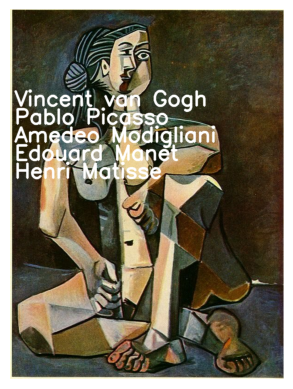

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/Pablo_Picasso_128.jpg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/model_2c'
sample_size = 256
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

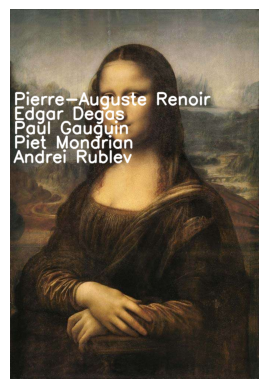

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo1.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2c'
sample_size = 256
output_num = 5
model_demo(image_path, model_path, art_dict, sample_size, output_num)

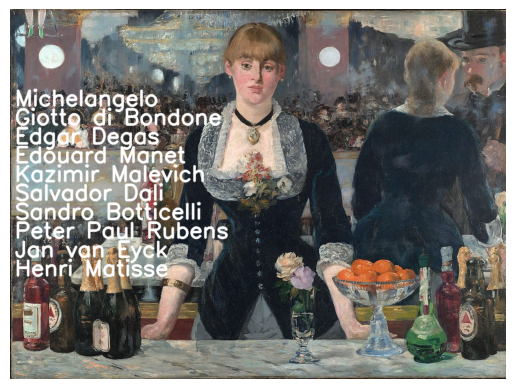

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo4.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2c'
sample_size = 256
output_num = 10

model_demo(image_path, model_path, art_dict, sample_size, output_num)

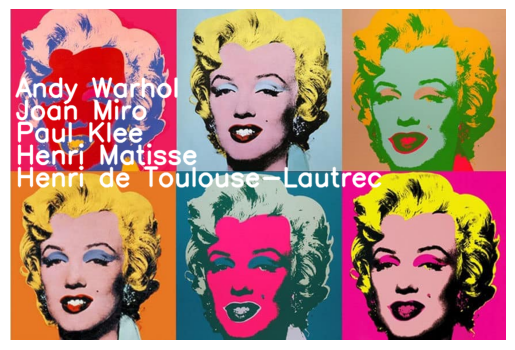

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo6.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2c'
sample_size = 256
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

## Model 4b Sampling(64x64)

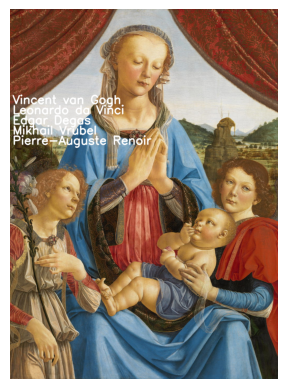

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/Leonardo_da_Vinci_1.jpg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/model4b'
sample_size = 64
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

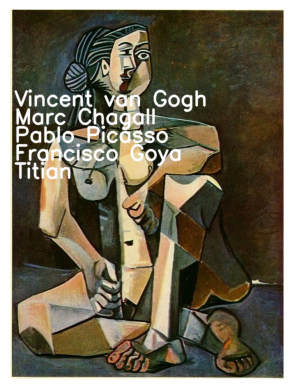

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/Pablo_Picasso_128.jpg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/model4b'
sample_size = 64
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

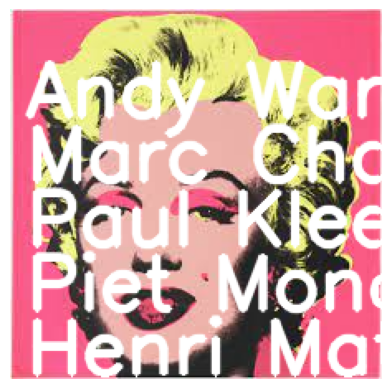

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo2.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model4b'
sample_size = 64
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

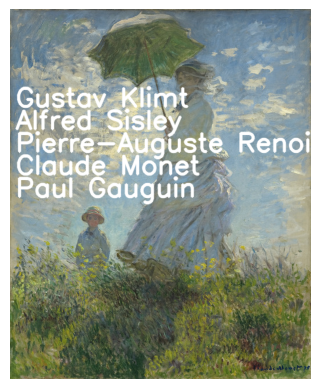

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo3.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model4b'
sample_size = 64
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

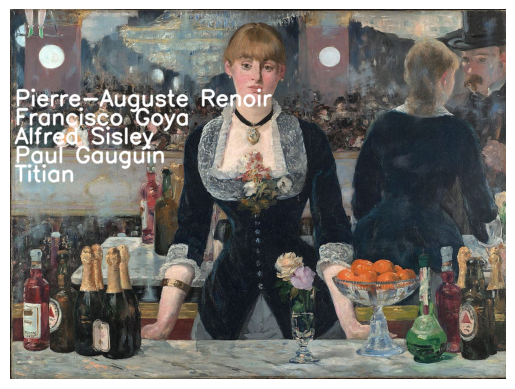

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo4.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model4b'
sample_size = 64
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

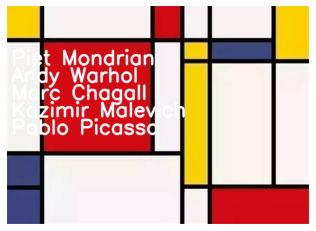

In [12]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo8.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model4b'
sample_size = 64
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

## Model 2d

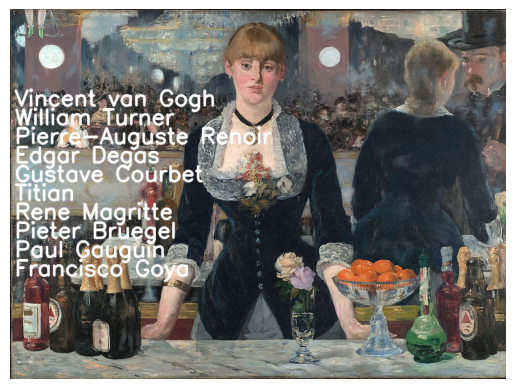

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo4.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2d'
sample_size = 256
output_num = 10

model_demo(image_path, model_path, art_dict, sample_size, output_num)

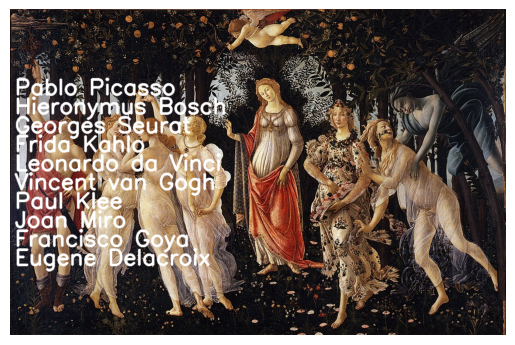

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo5.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2d'
sample_size = 256
output_num = 10

model_demo(image_path, model_path, art_dict, sample_size, output_num)

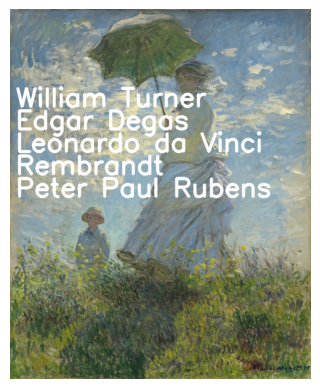

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo3.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2d'
sample_size = 256
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

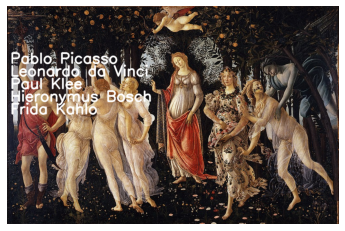

In [8]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo5.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2d'
sample_size = 256
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

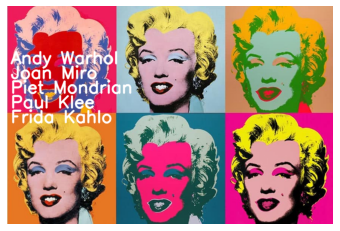

In [9]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo6.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2d'
sample_size = 256
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

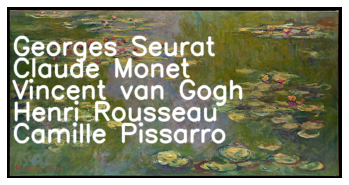

In [17]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/Demo7.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2d'
sample_size = 256
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

## Art forgery

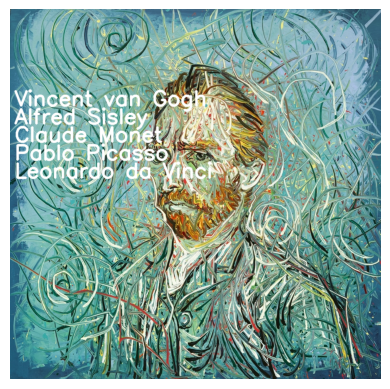

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/DemoF.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model4b'
sample_size = 64
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

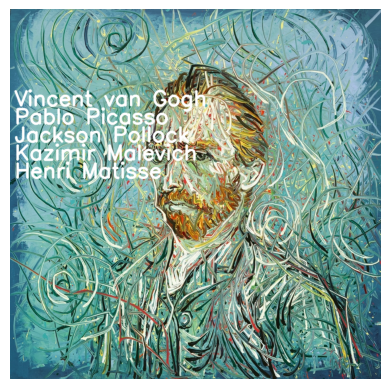

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/DemoF.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2c'
sample_size = 256
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

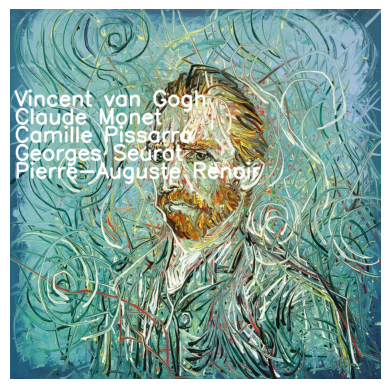

In [ ]:
image_path = 'gdrive/MyDrive/w251/w251_final_project_data/paintings/DemoF.jpeg'
model_path = 'gdrive/MyDrive/w251/w251_final_project_data/models/model_2d'
sample_size = 256
output_num = 5

model_demo(image_path, model_path, art_dict, sample_size, output_num)

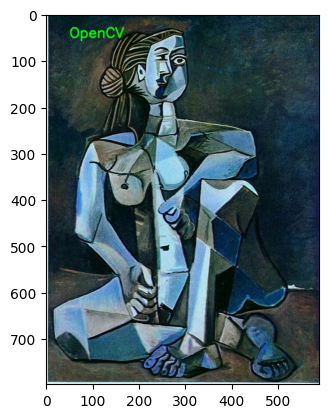

In [ ]:
# # path
# path = 'gdrive/MyDrive/w251/w251_final_project_data/Pablo_Picasso_128.jpg'
    
# # Reading an image in default mode
# image = cv2.imread(path)
    
# # Window name in which image is displayed

# # font
# font = cv2.FONT_HERSHEY_SIMPLEX
  
# # org
# org = (50, 50)
  
# # fontScale
# fontScale = 1
   
# # Blue color in BGR
# color = (0, 255, 0)
  
# # Line thickness of 2 px
# thickness = 2
   
# # Using cv2.putText() method
# image = cv2.putText(image, 'OpenCV', org, font, 
#                    fontScale, color, thickness, cv2.LINE_AA)
   
# # Displaying the image
# plt.imshow(image)